<a href="https://colab.research.google.com/github/nkimoto/signate/blob/main/SRWS-PSG/notebooks/ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch
!pip install transformers
!pip install scikit-learn
!pip install tqdm
!pip install optuna

     |████████████████████████████████| 2.9 MB 4.1 MB/s 
     |████████████████████████████████| 636 kB 41.9 MB/s 
     |████████████████████████████████| 895 kB 59.9 MB/s 
     |████████████████████████████████| 3.3 MB 62.0 MB/s 
     |████████████████████████████████| 52 kB 1.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 308 kB 2.8 MB/s 
     |████████████████████████████████| 80 kB 9.3 MB/s 
     |████████████████████████████████| 208 kB 36.7 MB/s 
     |████████████████████████████████| 75 kB 4.3 MB/s 
     |████████████████████████████████| 111 kB 43.5 MB/s 
     |████████████████████████████████| 144 kB 35.7 MB/s 
     |████████████████████████████████| 49 kB 5.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=3fa26b581a2d9987044fe933c3520f80bc0363e59dff6bbeabc1680ead3391d9
  Stored 

In [3]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import optuna.integration.lightgbm as lgb
import lightgbm as lgb_original
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import fbeta_score

In [4]:
# 学習結果の予測を出力
SAVE_PREDS_DATA_DIR = "/content/drive/MyDrive/signate/data/"
with open(SAVE_PREDS_DATA_DIR+"train_preds.pickle", mode="rb") as f:
    train_preds = pickle.load(f)

with open(SAVE_PREDS_DATA_DIR+"test_preds.pickle", mode="rb") as f:
    test_preds = pickle.load(f)

In [42]:
def get_train_test_preds(train_preds, test_preds):

    # ================================================
    # 学習データの結果統合
    # ================================================
    # formatにはtitle+abstractのデータを使用すること
    train_format = train_preds[list(train_preds.keys())[1]].copy()
    cols = train_format.columns
    train_format = train_format.loc[:, ~cols.str.contains("preds_")]

    # 1つのｄｆに結果を統合
    train_preds_df = train_format.copy()
    for key in train_preds.keys():
        cols = [f"preds_mean", f"preds_0", f"preds_1", f"preds_2", f"preds_3", f"preds_4"]
        new_cols = [f"{key}_preds_mean", f"{key}_preds_0", f"{key}_preds_1", f"{key}_preds_2", f"{key}_preds_3", f"{key}_preds_4"]
        train_preds_df[new_cols] = train_preds[key][cols].copy()
      
    # oofを結合
    path = "/content/drive/MyDrive/signate/results/"
    dir_name = [
                "results_pubmedbert_uncased_title/",
                "results_pubmedbert_uncased_title+abstract/",
                "results_scibert_scivocab_uncased_title/",
                "results_scibert_scivocab_uncased_title+abstract/",
                ]
    path_list = [path + f +"oof_df.csv" for f in dir_name]
    for i, key in enumerate(train_preds.keys()):
        new_col = f"{key}_oof_preds"
        train_preds_df[new_col] = pd.read_csv(path_list[i]).sort_values("id").reset_index(drop=True)["preds"]

    train_preds_df["num_words"] = train_preds_df["title+abstract"].str.count(" ")+1
    train_preds_df["only_title"] = train_preds_df["abstract"].isnull().astype(int)
    # word
    # 事前に抽出した特徴的な単語
    word_list = [
             "patient", "respect", "respective", "clinic", "evaluate", 
             "accuracy", "testing", "preformance", "value", "ample", 
             "patients", "sample", "bodies", "RT-PCR", "assay", 
             "negative", "RT", "T-", "positive", "preform",
             "SARS", "CoV", "diagnosis", "PCR", "specific", 
             "city", "0%", "diagnostic", "detection", "test", 
             "specificity", "detect", "sensitivity", "collect", "pharyngeal",
             "Lewy", "standard", "COVID", "evaluated", "tests", 
             "brain", "associate", "treat", "function", "press", 
             "hip", "fact", "beta", "increased", 
             ]

    for word in word_list:
        train_preds_df[f"{word}_count"] = train_preds_df["title+abstract"].str.count(word)


    # ================================================
    # テストデータの結果統合
    # ================================================
    # formatにはtitle+abstractのデータを使用すること
    test_format = test_preds[list(test_preds.keys())[1]].copy()
    cols = test_format.columns
    test_format = test_format.loc[:, ~cols.str.contains("preds_")]

    # 1つのｄｆに結果を統合
    test_preds_df = test_format.copy()
    for key in test_preds.keys():
        cols = [f"preds_mean", f"preds_0", f"preds_1", f"preds_2", f"preds_3", f"preds_4"]
        new_cols = [f"{key}_preds_mean", f"{key}_preds_0", f"{key}_preds_1", f"{key}_preds_2", f"{key}_preds_3", f"{key}_preds_4"]
        test_preds_df[new_cols] = test_preds[key][cols].copy()

    test_preds_df["num_words"] = test_preds_df["title+abstract"].str.count(" ")+1
    test_preds_df["only_title"] = test_preds_df["abstract"].isnull().astype(int)

    for word in word_list:
        test_preds_df[f"{word}_count"] = test_preds_df["title+abstract"].str.count(word)
    
    pred_cols = ["num_words", "only_title"] + [f"{word}_count" for word in word_list]

    return train_preds_df, test_preds_df, pred_cols


train_preds_df, test_preds_df, pred_cols = get_train_test_preds(train_preds, test_preds)


In [6]:
def fbeta(true, pred):
    return fbeta_score(true, pred, beta=7)

In [35]:
sample = pd.read_csv("/content/drive/MyDrive/signate/results_new/results_pubmedbert_uncased_title+abstract/oof_df.csv")

In [43]:
#preds = (train_preds_df["pubmedbert_uncased_title+abstract_preds_mean"] > border).astype(int)
preds = (train_preds_df["pubmedbert_uncased_title+abstract_oof_preds"] > border).astype(int)
true = train_preds_df["judgement"]
fbeta(true, preds)

0.9064273942501373

In [75]:
border = 0.0232086940504697
fbeta(train_preds_df["judgement"], (train_preds_df.loc[:, train_preds_df.columns.str.contains("abstract_oof")].mean(axis=1) > border).astype(int))

0.9216659604092258

In [95]:
(train_preds_df.loc[:, train_preds_df.columns.str.contains("abstract_oof")].mean(axis=1) > border).sum()

2168

In [119]:
%%time
seed = 471

cols = list(train_preds_df.columns[train_preds_df.columns.str.contains("abstract_oof_preds")])
cols = cols + pred_cols
X = train_preds_df.loc[:, cols]
y = train_preds_df["judgement"]
X_train = X.copy()
y_train = y.copy()
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=seed)
train_data = lgb.Dataset(X_train, y_train)

params = {'objective': 'binary',
          'metric': 'binary_logloss',
          'random_seed': seed}

tuner = lgb.LightGBMTunerCV(
    params, 
    train_data,
    nfold=5, 
    verbose_eval=100, 
    early_stopping_rounds=100,
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=seed),
    seed=seed,
    optuna_seed=seed
)

tuner.run()

[I 2021-10-04 12:17:45,489] A new study created in memory with name: no-name-c1710e01-bfe1-4364-b441-79a0727e8fae
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.0430447 + 0.00339737


feature_fraction, val_score: 0.040174:  14%|#4        | 1/7 [00:01<00:11,  1.90s/it]

[100]	cv_agg's binary_logloss: 0.0415423 + 0.00323388


feature_fraction, val_score: 0.038959:  29%|##8       | 2/7 [00:03<00:09,  1.83s/it]

[100]	cv_agg's binary_logloss: 0.0448486 + 0.00403815


feature_fraction, val_score: 0.038959:  43%|####2     | 3/7 [00:05<00:07,  1.86s/it]

[100]	cv_agg's binary_logloss: 0.0415081 + 0.00301752


feature_fraction, val_score: 0.038959:  57%|#####7    | 4/7 [00:07<00:05,  1.86s/it]

[100]	cv_agg's binary_logloss: 0.0423041 + 0.00322372


feature_fraction, val_score: 0.038959:  71%|#######1  | 5/7 [00:09<00:03,  1.85s/it]

[100]	cv_agg's binary_logloss: 0.043623 + 0.00430787


feature_fraction, val_score: 0.038959:  86%|########5 | 6/7 [00:11<00:01,  1.85s/it]

[100]	cv_agg's binary_logloss: 0.0436598 + 0.0041219


num_leaves, val_score: 0.038959:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.0515328 + 0.00493912


num_leaves, val_score: 0.038959:   5%|5         | 1/20 [00:04<01:21,  4.30s/it]

[100]	cv_agg's binary_logloss: 0.0496222 + 0.00403037


num_leaves, val_score: 0.038959:  10%|#         | 2/20 [00:07<01:04,  3.58s/it]

[100]	cv_agg's binary_logloss: 0.049808 + 0.00425121


num_leaves, val_score: 0.038959:  15%|#5        | 3/20 [00:10<00:57,  3.40s/it]

[100]	cv_agg's binary_logloss: 0.0527756 + 0.00576319


num_leaves, val_score: 0.038959:  20%|##        | 4/20 [00:16<01:12,  4.53s/it]

[100]	cv_agg's binary_logloss: 0.05169 + 0.00504935


num_leaves, val_score: 0.038959:  25%|##5       | 5/20 [00:21<01:09,  4.62s/it]

[100]	cv_agg's binary_logloss: 0.0375337 + 0.0029028


num_leaves, val_score: 0.037175:  30%|###       | 6/20 [00:22<00:47,  3.43s/it]

[100]	cv_agg's binary_logloss: 0.052946 + 0.00483148


num_leaves, val_score: 0.037175:  35%|###5      | 7/20 [00:28<00:54,  4.21s/it]

[100]	cv_agg's binary_logloss: 0.0516954 + 0.00462669


num_leaves, val_score: 0.037175:  40%|####      | 8/20 [00:33<00:53,  4.47s/it]

[100]	cv_agg's binary_logloss: 0.0523427 + 0.00412535


num_leaves, val_score: 0.037175:  45%|####5     | 9/20 [00:39<00:54,  4.94s/it]

[100]	cv_agg's binary_logloss: 0.0509675 + 0.00507635


num_leaves, val_score: 0.037175:  50%|#####     | 10/20 [00:43<00:46,  4.64s/it]

[100]	cv_agg's binary_logloss: 0.0374721 + 0.00302971


num_leaves, val_score: 0.037175:  55%|#####5    | 11/20 [00:44<00:31,  3.52s/it]

[100]	cv_agg's binary_logloss: 0.0374721 + 0.00302971


num_leaves, val_score: 0.037175:  60%|######    | 12/20 [00:45<00:21,  2.74s/it]

[100]	cv_agg's binary_logloss: 0.0375076 + 0.00303456


num_leaves, val_score: 0.037175:  65%|######5   | 13/20 [00:46<00:15,  2.20s/it]

[100]	cv_agg's binary_logloss: 0.0461743 + 0.00288334


num_leaves, val_score: 0.037175:  70%|#######   | 14/20 [00:48<00:13,  2.28s/it]

[100]	cv_agg's binary_logloss: 0.0430914 + 0.0032642


num_leaves, val_score: 0.037175:  75%|#######5  | 15/20 [00:50<00:10,  2.18s/it]

[100]	cv_agg's binary_logloss: 0.0431151 + 0.00301532


num_leaves, val_score: 0.037175:  80%|########  | 16/20 [00:52<00:08,  2.13s/it]

[100]	cv_agg's binary_logloss: 0.0499806 + 0.00442651


num_leaves, val_score: 0.037175:  85%|########5 | 17/20 [00:55<00:07,  2.43s/it]

[100]	cv_agg's binary_logloss: 0.0425651 + 0.00321825


num_leaves, val_score: 0.037175:  90%|######### | 18/20 [00:57<00:04,  2.27s/it]

[100]	cv_agg's binary_logloss: 0.0387742 + 0.0040442
[200]	cv_agg's binary_logloss: 0.0375096 + 0.00355338
[300]	cv_agg's binary_logloss: 0.0373235 + 0.00348231
[400]	cv_agg's binary_logloss: 0.0373302 + 0.00342672


num_leaves, val_score: 0.037175:  95%|#########5| 19/20 [00:59<00:02,  2.13s/it]

[500]	cv_agg's binary_logloss: 0.0373521 + 0.00342111
[100]	cv_agg's binary_logloss: 0.047018 + 0.00293462


bagging, val_score: 0.037175:   0%|          | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.0387339 + 0.00367428


bagging, val_score: 0.037175:  10%|#         | 1/10 [00:01<00:11,  1.28s/it]

[100]	cv_agg's binary_logloss: 0.0389936 + 0.00338096


bagging, val_score: 0.037175:  20%|##        | 2/10 [00:02<00:09,  1.15s/it]

[100]	cv_agg's binary_logloss: 0.0374018 + 0.00352271


bagging, val_score: 0.037134:  30%|###       | 3/10 [00:03<00:07,  1.13s/it]

[100]	cv_agg's binary_logloss: 0.0379575 + 0.00278908


bagging, val_score: 0.037134:  40%|####      | 4/10 [00:04<00:07,  1.17s/it]

[100]	cv_agg's binary_logloss: 0.0379413 + 0.00292446


bagging, val_score: 0.037134:  50%|#####     | 5/10 [00:06<00:06,  1.23s/it]

[100]	cv_agg's binary_logloss: 0.0380269 + 0.00241241


bagging, val_score: 0.037134:  60%|######    | 6/10 [00:07<00:04,  1.19s/it]

[100]	cv_agg's binary_logloss: 0.0382196 + 0.00286149


bagging, val_score: 0.037134:  70%|#######   | 7/10 [00:08<00:03,  1.20s/it]

[100]	cv_agg's binary_logloss: 0.0385397 + 0.00337592


bagging, val_score: 0.037134:  80%|########  | 8/10 [00:09<00:02,  1.20s/it]

[100]	cv_agg's binary_logloss: 0.037888 + 0.00282072


bagging, val_score: 0.037134:  90%|######### | 9/10 [00:10<00:01,  1.18s/it]

[100]	cv_agg's binary_logloss: 0.0375857 + 0.00314683


feature_fraction_stage2, val_score: 0.036989:   0%|          | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.0375545 + 0.00290053


feature_fraction_stage2, val_score: 0.036989:  17%|#6        | 1/6 [00:01<00:05,  1.06s/it]

[100]	cv_agg's binary_logloss: 0.0374864 + 0.00301381


feature_fraction_stage2, val_score: 0.036989:  33%|###3      | 2/6 [00:02<00:04,  1.06s/it]

[100]	cv_agg's binary_logloss: 0.0376817 + 0.00339184


feature_fraction_stage2, val_score: 0.036989:  50%|#####     | 3/6 [00:03<00:03,  1.07s/it]

[100]	cv_agg's binary_logloss: 0.0377671 + 0.0028906


feature_fraction_stage2, val_score: 0.036989:  67%|######6   | 4/6 [00:04<00:02,  1.08s/it]

[100]	cv_agg's binary_logloss: 0.0381528 + 0.00337617


feature_fraction_stage2, val_score: 0.036989:  83%|########3 | 5/6 [00:05<00:01,  1.07s/it]

[100]	cv_agg's binary_logloss: 0.0375857 + 0.00314683


regularization_factors, val_score: 0.036989:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.0375077 + 0.00315869


regularization_factors, val_score: 0.036903:   5%|5         | 1/20 [00:01<00:21,  1.13s/it]

[100]	cv_agg's binary_logloss: 0.0370885 + 0.0032402


regularization_factors, val_score: 0.036903:  10%|#         | 2/20 [00:02<00:20,  1.12s/it]

[100]	cv_agg's binary_logloss: 0.0375078 + 0.00315881


regularization_factors, val_score: 0.036903:  15%|#5        | 3/20 [00:03<00:19,  1.13s/it]

[100]	cv_agg's binary_logloss: 0.0371231 + 0.00330361


regularization_factors, val_score: 0.036903:  20%|##        | 4/20 [00:04<00:18,  1.13s/it]

[100]	cv_agg's binary_logloss: 0.037027 + 0.00318862


regularization_factors, val_score: 0.036663:  25%|##5       | 5/20 [00:05<00:16,  1.12s/it]

[100]	cv_agg's binary_logloss: 0.0373326 + 0.00305146


regularization_factors, val_score: 0.036663:  30%|###       | 6/20 [00:06<00:15,  1.09s/it]

[100]	cv_agg's binary_logloss: 0.0371173 + 0.00350263


regularization_factors, val_score: 0.036663:  35%|###5      | 7/20 [00:07<00:13,  1.07s/it]

[100]	cv_agg's binary_logloss: 0.037625 + 0.0031538


regularization_factors, val_score: 0.036663:  40%|####      | 8/20 [00:08<00:13,  1.09s/it]

[100]	cv_agg's binary_logloss: 0.0375402 + 0.00315514


regularization_factors, val_score: 0.036663:  45%|####5     | 9/20 [00:09<00:11,  1.08s/it]

[100]	cv_agg's binary_logloss: 0.0375016 + 0.00316676


regularization_factors, val_score: 0.036663:  50%|#####     | 10/20 [00:10<00:10,  1.09s/it]

[100]	cv_agg's binary_logloss: 0.0374586 + 0.00308109


regularization_factors, val_score: 0.036663:  55%|#####5    | 11/20 [00:12<00:09,  1.08s/it]

[100]	cv_agg's binary_logloss: 0.0366511 + 0.00352777


regularization_factors, val_score: 0.036646:  60%|######    | 12/20 [00:13<00:09,  1.16s/it]

[100]	cv_agg's binary_logloss: 0.0367558 + 0.00315027


regularization_factors, val_score: 0.036646:  65%|######5   | 13/20 [00:14<00:08,  1.24s/it]

[100]	cv_agg's binary_logloss: 0.0369127 + 0.00310163


regularization_factors, val_score: 0.036501:  70%|#######   | 14/20 [00:15<00:07,  1.20s/it]

[100]	cv_agg's binary_logloss: 0.0366968 + 0.00340436


regularization_factors, val_score: 0.036501:  75%|#######5  | 15/20 [00:17<00:06,  1.25s/it]

[100]	cv_agg's binary_logloss: 0.0370711 + 0.00316109


regularization_factors, val_score: 0.036501:  80%|########  | 16/20 [00:18<00:04,  1.20s/it]

[100]	cv_agg's binary_logloss: 0.0369369 + 0.00336499


regularization_factors, val_score: 0.036501:  85%|########5 | 17/20 [00:19<00:03,  1.18s/it]

[100]	cv_agg's binary_logloss: 0.0371325 + 0.00315004


regularization_factors, val_score: 0.036501:  90%|######### | 18/20 [00:20<00:02,  1.17s/it]

[100]	cv_agg's binary_logloss: 0.0372925 + 0.00367425


regularization_factors, val_score: 0.036501:  95%|#########5| 19/20 [00:21<00:01,  1.15s/it]

[100]	cv_agg's binary_logloss: 0.0375959 + 0.0031851


min_data_in_leaf, val_score: 0.036501:   0%|          | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.0370683 + 0.00319764


min_data_in_leaf, val_score: 0.036501:  20%|##        | 1/5 [00:01<00:04,  1.08s/it]

[100]	cv_agg's binary_logloss: 0.0366605 + 0.0028166


min_data_in_leaf, val_score: 0.036338:  40%|####      | 2/5 [00:02<00:03,  1.10s/it]

[100]	cv_agg's binary_logloss: 0.0369562 + 0.00319634


min_data_in_leaf, val_score: 0.036338:  60%|######    | 3/5 [00:03<00:02,  1.09s/it]

[100]	cv_agg's binary_logloss: 0.0368555 + 0.0031887


min_data_in_leaf, val_score: 0.036338:  80%|########  | 4/5 [00:04<00:01,  1.10s/it]

[100]	cv_agg's binary_logloss: 0.0369385 + 0.00299267


min_data_in_leaf, val_score: 0.036338: 100%|##########| 5/5 [00:05<00:00,  1.10s/it]

CPU times: user 15min 39s, sys: 10.2 s, total: 15min 49s
Wall time: 2min 2s


In [120]:
best_params = tuner.best_params
print("  Params: ")
for key, value in best_params.items():
  print(f"    {key}: {value}")

# ベストパラメータで学習
model = lgb_original.train(best_params, train_data)
preds_proba = model.predict(X_train)

border = 0.0232086940504697
print(fbeta_score(y_train, model.predict(X_train) > border, beta=7))
#print(fbeta_score(y_test, model.predict(X_test) > border, beta=7))

  Params: 
    objective: binary
    metric: binary_logloss
    random_seed: 471
    feature_pre_filter: False
    lambda_l1: 2.644893750477833
    lambda_l2: 0.07160503199634856
    num_leaves: 7
    feature_fraction: 0.5
    bagging_fraction: 0.7401674710608591
    bagging_freq: 1
    min_child_samples: 100
0.9258410486754056


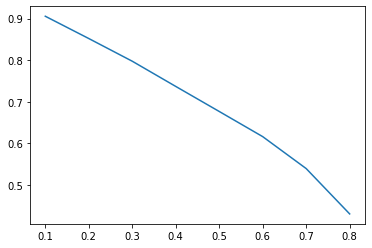

In [121]:
score_list = [fbeta_score(y_train, preds_proba > border, beta=7) for border in np.arange(0.1, 0.9, 0.1)]
plt.plot(np.arange(0.1, 0.9, 0.1), np.array(score_list))

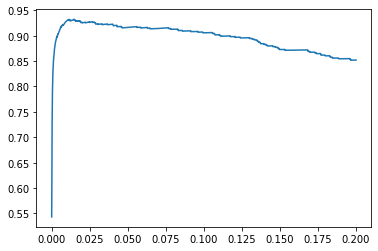

In [122]:
score_list = [fbeta_score(y_train, preds_proba > border, beta=7) for border in np.arange(0.0001, 0.2, 0.0001)]
plt.plot(np.arange(0.0001, 0.2, 0.0001), np.array(score_list))

In [123]:
border = 0.0232086940504697
border = np.arange(0.0001, 0.2, 0.0001)[np.array(score_list).argmax()]
print(border)
preds = preds_proba > border
print(fbeta_score(y_train, preds, beta=7))

0.0148
0.9322598220231249


In [124]:
test_cols = list(test_preds_df.columns[test_preds_df.columns.str.contains("preds_mean")])
test_cols = test_cols + pred_cols
test = test_preds_df.loc[:, test_cols]
t_preds = model.predict(test)
output = t_preds > border

sub = pd.read_csv("/content/drive/MyDrive/signate/rawdata/" + "sample_submit.csv", header=None)
sub.columns = ["id", "judgement"]
sub["judgement"] = output
sub["judgement"] = sub["judgement"].astype(int)
sub.to_csv("/content/drive/MyDrive/signate/data/" + "submission_abst_change_border.csv", index=False, header=False)

In [65]:
# 他のモデルの結果と比較
sample = pd.read_csv("/content/drive/MyDrive/signate/results/results_pubmedbert_uncased_title+abstract/" + "submission.csv", header=None)

In [66]:
sample[1].sum()

3159

In [88]:
sub["judgement"].sum()

3429

In [68]:
(sub["judgement"] - sample[1]).abs().sum()

1016